<a href="https://colab.research.google.com/github/suzukimain/diffusers_in_Colab/blob/main/diffusers_in_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title   #Step1.セットアップ (Setup) { run: "auto", display-mode: "form"}

print("実行中…")
import locale #この2行は非常に重要
locale.getpreferredencoding = lambda: "UTF-8"

Google_driveに接続 = False  # @param {type:"boolean"}
#@markdown Googleドライブに保存したいときにチェックをしてください
from google.colab import drive
import google.colab.drive as drive
if Google_driveに接続:
  Gdrive="GoogleDrive: \033[32m接続成功\033[0m"
  try:
    drive.mount('/content/drive')
  except:
    Gdrive="GoogleDrive: \033[31m接続失敗\033[0m"
else:
  Gdrive="GoogleDrive: \033[33m接続なし\033[0m"
  if drive._os.path.ismount('/content/drive'):
     drive.flush_and_unmount()
     print("GoogleDriveの接続を解除しました")

import os

#import logging#エラーを非表示に
#logging.getLogger("diffusers").setLevel(logging.ERROR)

try:
  import torch
  import diffusers
  import transformers
  import accelerate
  import scipy
  import safetensors
  import ftfy
  import regex
  import tqdm
  import xformers
  import sentencepiece
  import pysbd
  import huggingface_hub
  import sacremoses
  import omegaconf

except:
  try:
    !pip install git+https://github.com/huggingface/diffusers.git -q
    !git clone https://github.com/alexblattner/modified-euler-samplers-for-sonar-diffusers.git -q
    !pip install transformers==4.33.3  accelerate scipy==1.10.1 ftfy==6.1.1 regex==2022.10.31 tqdm==4.65.0 scipy==1.10.1 sentencepiece==0.1.99 pysbd==0.3.4 xformers sacremoses omegaconf -q
    import torch
    import diffusers
    import transformers
    import accelerate
    import scipy
    import safetensors
    import ftfy
    import regex
    import tqdm
    import xformers
    import sentencepiece
    import pysbd
    import huggingface_hub
    import sacremoses
    import omegaconf

  except:
    raise RuntimeError("ランタイムをGPUに変更お願いします。またはページの再読み込みをお願いします")

from transformers.utils import logging
transformers.utils.logging.set_verbosity_error()


import time
import sys
import spacy
import codecs
import pickle
import torch
import random
import numpy as np
import transformers
import sentencepiece
import ipywidgets as widgets
from PIL import Image,PngImagePlugin
from datetime import datetime
from IPython.display import display, Markdown
from diffusers import (StableDiffusionPipeline, DPMSolverMultistepScheduler, EulerDiscreteScheduler,
                       StableDiffusionImg2ImgPipeline, DiffusionPipeline, AutoencoderKL,
                       UNet2DConditionModel, PNDMScheduler,
                       schedulers,)
from diffusers import (
    DDPMScheduler,
    DDIMScheduler,
    PNDMScheduler,
    LMSDiscreteScheduler,
    EulerDiscreteScheduler,
    EulerAncestralDiscreteScheduler,
    DPMSolverMultistepScheduler,
)
from transformers import (pipeline, CLIPTextModel, CLIPTokenizer, AutoModel, AutoTokenizer)
from huggingface_hub import hf_hub_download
from safetensors.torch import save_file
from torch import Generator
from google.colab import drive
import google.colab.drive as drive

#ソナーのインポート
%cd /content/modified-euler-samplers-for-sonar-diffusers
sys.path.append( "./EulerANew.py" )
sys.path.append( "./EulerNew.py" )
!python EulerANew.py
!python EulerNew.py
import EulerNew,EulerANew
from EulerANew import EulerA
from EulerNew import Euler

step1_finish=True

if drive._os.path.ismount('/content/drive'):
  Connect_Gdrive="\033[34mGoogleDrive: 接続成功\033[0m"

else:
  Connect_Gdrive="\033[34mGoogleDrive: \033[33m接続なし\033[0m"
print("\n\033[34m___________________________________________\033[0m\n")
print(Connect_Gdrive)
print("\n\033[32mセットアップが完了しました。\033[0m")

実行中…
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 35.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 52.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 30.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 47.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 770.5/770.5 kB 52.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 73.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.1/71.1 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.6/211.6 M

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

/content/modified-euler-samplers-for-sonar-diffusers

___________________________________________

GoogleDrive: 接続なし

セットアップが完了しました。


In [2]:
#@title  #Step2.モードの選択 (Mode Selection){display-mode: "form"}

#"\033[31m先にStep.1を実行してください\033[0m"


# @markdown >使用するモデルの切り替え (model change)

model_select = "Counterfeit-V2.5(Anime)(better)" # @param ["stable diffusion-v2.1(basic)", "Counterfeit-V2.5(Anime)(better)", "loliDiffusion(Anime)", "waifu diffusion-v1.4(Anime)", "Anything-v3.0(Anime)", "Anything-v4.5(Anime)", "anything-midjourney-v-4-1(Anime)", "ACertainThing(Anime)", "anime-kawai-diffusion(Anime)", "AB4.5_AC0.2(Anime)", "basil_mix(Anime)", "Counterfeit(Anime)", "Counterfeit-V2.0(Anime)","chilled_remix(Anime)","chilled_reversemix(Anime)", "Double-Exposure-Diffusion(Anime)", "EimisAnimeDiffusion_1.0v(Anime)", "7th_Layer(Anime)", "Riga_Collection(Anime)", "Waifu-Diffusers(Anime)","JWST-Deep-Space-diffusion(space)","sd-db-epic-space-machine(space_ship)","spacemidj(space)","nasa-space-v2(space)","openjourney-v4(Reality)", "Realistic_Vision_V2.0(Reality)", "meinamix_meinaV10(Reality)"] {allow-input: true}

#削除モデル(使えないもの),"nasa_space_v2(space)","loliDiffusion(Anime)","chilled_remix(Anime)"

#@markdown モデルの選択方法

#@markdown * ボックスの右の三角を押すと出るリストから選択

#@markdown * URLを入力 ( **hugfaceにあるモデルのみ** )

#@markdown * hugface_pathを入力 ( **diffusersのみ** )

# @markdown >モードの切り替え (mode change)
mode_select = "Nomal(better)" #@param ["Nomal(better)","Quick"]

#@markdown * "Nomal" 品質と生成時間のバランス重視です(fp32)

#@markdown * "Quick" 少し品質が低下する代わりに生成時間が短縮します(fp16)

#@markdown >入力形式の指定

入力形式 = "text_only(better)" #@param ["text_only(better)", "image_and_text"]

#@markdown * text_only : テキストから画像( txt2img )

#@markdown * image_and_text : 画像から画像( img2img )

#@markdown >vaeを選択
vaeを指定 = "default(better)" # @param ["default(better)", "waifu-diffusion","Counterfeit-V2.5","anything-v3.0"]
#@markdown defaultを選択した場合、モデルに含まれている本来のvaeを使用します

#@markdown >スケジューラーを変更

Scheduler_select = "EulerA" # @param ["EulerA", "Euler","dpm","ddpm","ddim","pndm","lms"]

# @markdown ノイズの入力に使用するSchedulersを変更します。

# @markdown * EulerA ( EulerAncestralDiscreteScheduler ) : 画像の結果にランダム性をもたらします

# @markdown * Euler (   EulerDiscreteScheduler ) : 画像に統一性をもたせます

#@markdown 上記以外のスケジューラーはmoment関連のパラメータが使用出来ません。

#@markdown * DDPM : 生成速度を多少犠牲にする代わりに画質が高いです。(迷った場合推奨します)

# @markdown >フィルターを調整

# @markdown **注意事項 : 変更する時は注意して下さい**

Filter_off = False  # @param {type:"boolean"}

# @markdown 追記:人が映り込んだだけでフィルタリングされることがあったので追加しました



if "step1_finish" not in locals() or not step1_finish:
  raise NameError("\033[33m先にStep.1の実行をお願いします\033[0m")

model_id =""
model_name =""
can_EN=False
input_url=False
vae_name=""
model_file=""


if vaeを指定 == "waifu-diffusion":
  vae_name="hakurei/waifu-diffusion"

elif vaeを指定 == "Counterfeit-V2.5":
  vae_name= "gsdf/Counterfeit-V2.5"

elif vaeを指定 == "anything-v3.0":
  vae_name= "Linaqruf/anything-v3.0"

#laion/CLIP-ViT-H-14-laion2B-s32B-b79K


if not vaeを指定 == "default(better)":
  vae_change=True
  try:
    vae = AutoencoderKL.from_pretrained(vae_name)
  except:
    vae = AutoencoderKL.from_pretrained(vae_name , subfolder="vae")
else:
  vae=""
  vae_change=False

components_check = (model_select,mode_select,vaeを指定,Scheduler_select,Filter_off)
can_use_components=False#初期値
if "components_check_old" not in  locals():
  components_check_old=str(components_check)
  can_use_components=False
else:
  if components_check_old==str(components_check):
    can_use_components=True
  else:
    can_use_components=False
  components_check_old=str(components_check)


def print_text():
  if mode_select == "Nomal(better)":
     mode_text="mode: Nomal\n"
  else:
     mode_text="mode: Quick\n"
  return mode_text

def print_format():
  if 入力形式 == "text_only(better)":
    word_format="入力形式: text_only (txt2img)\n"
  else:
    word_format="入力形式: image_and_text (img2img)\n"
  return word_format

mode_text=print_text()
word_format=print_format()


def result():
  if Filter_off == False:
     filter_level = "フィルターの強度:通常"
  else:
     filter_level = "\033[33mフィルターの強度:無効\033[0m"
  return filter_level



device = "cuda" if torch.cuda.is_available() else "cpu"

def model_select_type_check(model_select):
  #初期値
  repo_name, model_name, word, branch, file_name ,model_url= "", "", "", "", "",""
  input_url=False
  Error_M1=('''URLを読み込めませんでした。この機能がサポートしている形式は次の通りです。
            形式:"https://huggingface.co/<repo_name>/<model_name>/blob/main/<path_to_file>.safetensors"
            例1: "https://huggingface.co/gsdf/Counterfeit-V3.0/blob/main/Counterfeit-V3.0.safetensors"
            例2: "https://huggingface.co/runwayml/stable-diffusion-v1-5/blob/main/v1-5-pruned.ckpt"
            補足:huggingfaceにあれば、diffusersのタグがついていないモデルでも、ほとんどの場合使用できます。
            ''')
  Error_M2=('''hugface_pathを読み込めませんでした。この機能がサポートしている形式は次の通りです。
            形式: <repo_name>/<model_name>"
            例1: "Linaqruf/anything-v3.0"
            例2: "stabilityai/stable-diffusion-2-1"
            補足1:diffusersのタグがついているモデルのみを対象としています
            補足2: 次のモデルのみ、モデル名のみで読み込めます。
            (下のモデル名をコピー&ペースト、または、model_selectの右側の三角を押すと出てくるドロップダウンからお選びください。)

            "stable diffusion-v2.1"
            "waifu diffusion-v1.4"
            "Anything-v3.0"
            "anything-midjourney-v-4-1"
            "Anything-v4.5"
            "AB4.5_AC0.2"
            "basil_mix"
            "Waifu-Diffusers"
            "Double-Exposure-Diffusion"
            "openjourney-v4"
            "ACertainThing"
            "Counterfeit-V2.0"
            "Counterfeit-V2.5"
            "7th_Layer"
            "EimisAnimeDiffusion_1.0v"
            "Riga_Collection"
            "anime-kawai-diffusion"
            "Realistic_Vision_V2.0"
            "meinamix_meinaV10"
            "loliDiffusion"
            ''')
  if model_select.startswith("https://huggingface.co/"):
    try:
      trimmed_url = model_select.replace("https://huggingface.co/", "")
        # 区切り文字 "/" で分割
      segments = trimmed_url.split("/")
        # 変数に割り当て
      repo_name, model_name, word , branch, file_name = segments[:5]
    except:
      raise ValueError(Error_M1)
    model_url=model_select
    input_url=True
  #diffusersライブラリのみ
  elif "/" in model_select and model_select.count("/") == 1:
    model_select_keyword = model_select.split("/")
    repo_name, model_name = model_select_keyword[:2]
  else:
    raise ValueError(Error_M2)
  return model_name, input_url,model_url




#   モデルの選択肢と対応する情報を辞書に保存する
#<model_select>:(<model_id>,<model_name>,<can_EN>,<input_url>,<model_url>)
model_dict = {
    "stable diffusion-v2.1(basic)" : ("stabilityai/stable-diffusion-2-1", "stable_diffusion-v2.1", False, False, ""),
    "waifu diffusion-v1.4(Anime)": ("hakurei/waifu-diffusion", "waifu_diffusion-v1.4", False, False, ""),
    "Anything-v3.0(Anime)": ("Linaqruf/anything-v3.0", "Anything-v3.0", True, False, ""),
    "anything-midjourney-v-4-1(Anime)": ("Joeythemonster/anything-midjourney-v-4-1", "anything-midjourney-v-4-1", True, False, ""),
    "Anything-v4.5(Anime)": ("shibal1/anything-v4.5-clone", "Anything-v4.5", False, False, ""),
    "AB4.5_AC0.2(Anime)": ("aioe/AB4.5_AC0.2", "AB4.5_AC0.2", False, False, ""),
    "basil_mix(Anime)": ("nuigurumi/basil_mix", "basil_mix", True, False, ""),
    "Waifu-Diffusers(Anime)": ("Nilaier/Waifu-Diffusers", "Waifu-Diffusers", True, False, ""),
    "Double-Exposure-Diffusion(Anime)": ("joachimsallstrom/Double-Exposure-Diffusion", "Double-Exposure-Diffusion", True, False, ""),
    "openjourney-v4(Reality)": ("prompthero/openjourney-v4", "openjourney-v4", True, False, ""),
    "ACertainThing(Anime)": ("JosephusCheung/ACertainThing", "ACertainThing", True, False, ""),
    "Counterfeit-V2.0(Anime)": ("gsdf/Counterfeit-V2.0", "Counterfeit-V2.0", True, False, ""),
    "Counterfeit-V2.5(Anime)(better)": ("gsdf/Counterfeit-V2.5", "Counterfeit-V2.5", True, False, ""),
    "chilled_remix(Anime)":("chilled_remix","chilled_remix" ,False,True,"https://huggingface.co/sazyou-roukaku/chilled_remix/blob/main/chilled_remix_v2.safetensors"),
    "chilled_reversemix(Anime)":("chilled_reversemix","chilled_reversemix" ,False,True,"https://huggingface.co/sazyou-roukaku/chilled_remix/blob/main/chilled_reversemix_v2.safetensors"),
    "7th_Layer(Anime)": ("syaimu/7th_test", "7th_Layer", True, False, ""),
    "EimisAnimeDiffusion_1.0v(Anime)": ("eimiss/EimisAnimeDiffusion_1.0v", "EimisAnimeDiffusion_1.0v", True, False, ""),
    "JWST-Deep-Space-diffusion(space)" : ("dallinmackay/JWST-Deep-Space-diffusion", "JWST-Deep-Space-diffusion", False, False, ""),
    "Riga_Collection(Anime)": ("natsusakiyomi/Riga_Collection", "Riga_Collection", True, False, ""),
    "anime-kawai-diffusion(Anime)": ("Ojimi/anime-kawai-diffusion", "anime-kawai-diffusion", True, False, ""),
    "Realistic_Vision_V2.0(Reality)": ("SG161222/Realistic_Vision_V2.0", "Realistic_Vision_V2.0", True, False, ""),
    "sd-db-epic-space-machine(space_ship)" : ("rabidgremlin/sd-db-epic-space-machine", "sd-db-epic-space-machine", False, False, ""),
    "spacemidj(space)" : ("Falah/spacemidj", "spacemidj", False, False, ""),
    "meinamix_meinaV10(Reality)": ("namvuong96/civit_meinamix_meinaV10", "meinamix_meinaV10", True, False, ""),
    "nasa-space-v2(space)" : ("sd-dreambooth-library/nasa-space-v2-768", "nasa-space-v2", False, False, ""),
    "loliDiffusion(Anime)": ("loliDiffusion","loliDiffusion" ,False,True,"https://huggingface.co/JosefJilek/loliDiffusion/blob/main/loliDiffusionV0.9.3_AOM2-SFW_0.8M7.8-CLIP_VAE_PURIFIED.safetensors"),
    #ここからほぼ同じ
    "stable diffusion-v2.1" : ("stabilityai/stable-diffusion-2-1", "stable_diffusion-v2.1", False, False, ""),
    "waifu diffusion-v1.4": ("hakurei/waifu-diffusion", "waifu_diffusion-v1.4", False, False, ""),
    "Anything-v3.0": ("Linaqruf/anything-v3.0", "Anything-v3.0", True, False, ""),
    "anything-midjourney-v-4-1": ("Joeythemonster/anything-midjourney-v-4-1", "anything-midjourney-v-4-1", True, False, ""),
    "Anything-v4.5": ("shibal1/anything-v4.5-clone", "Anything-v4.5", False, False, ""),
    "AB4.5_AC0.2": ("aioe/AB4.5_AC0.2", "AB4.5_AC0.2", False, False, ""),
    "basil_mix": ("nuigurumi/basil_mix", "basil_mix", True, False, ""),
    "Waifu-Diffusers": ("Nilaier/Waifu-Diffusers", "Waifu-Diffusers", True, False, ""),
    "Double-Exposure-Diffusion": ("joachimsallstrom/Double-Exposure-Diffusion", "Double-Exposure-Diffusion", True, False, ""),
    "openjourney-v4": ("prompthero/openjourney-v4", "openjourney-v4", True, False, ""),
    "ACertainThing": ("JosephusCheung/ACertainThing", "ACertainThing", True, False, ""),
    "Counterfeit-V2.0": ("gsdf/Counterfeit-V2.0", "Counterfeit-V2.0", True, False, ""),
    "Counterfeit-V2.5": ("gsdf/Counterfeit-V2.5", "Counterfeit-V2.5", True, False, ""),
    "chilled_remix":("chilled_remix","chilled_remix" ,False,True,"https://huggingface.co/sazyou-roukaku/chilled_remix/blob/main/chilled_remix_v2.safetensors"),
    "chilled_reversemix":("chilled_reversemix","chilled_reversemix" ,False,True,"https://huggingface.co/sazyou-roukaku/chilled_remix/blob/main/chilled_reversemix_v2.safetensors"),
    "7th_Layer": ("syaimu/7th_test", "7th_Layer", True, False, ""),
    "EimisAnimeDiffusion_1.0v": ("eimiss/EimisAnimeDiffusion_1.0v", "EimisAnimeDiffusion_1.0v", True, False, ""),
    "JWST-Deep-Space-diffusion" : ("dallinmackay/JWST-Deep-Space-diffusion", "JWST-Deep-Space-diffusion", False, False, ""),
    "Riga_Collection": ("natsusakiyomi/Riga_Collection", "Riga_Collection", True, False, ""),
    "sd-db-epic-space-machine" : ("rabidgremlin/sd-db-epic-space-machine", "sd-db-epic-space-machine", False, False, ""),
    "spacemidj" : ("Falah/spacemidj", "spacemidj", False, False, ""),
    "anime-kawai-diffusion": ("Ojimi/anime-kawai-diffusion", "anime-kawai-diffusion", True, False, ""),
    "Realistic_Vision_V2.0": ("SG161222/Realistic_Vision_V2.0", "Realistic_Vision_V2.0", True, False, ""),
    "nasa-space-v2" : ("sd-dreambooth-library/nasa-space-v2-768", "nasa-space-v2", False, False, ""),
    "meinamix_meinaV10": ("namvuong96/civit_meinamix_meinaV10", "meinamix_meinaV10", True, False, ""),
    "loliDiffusion": ("loliDiffusion","loliDiffusion" ,False,True,"https://huggingface.co/JosefJilek/loliDiffusion/blob/main/loliDiffusionV0.9.3_AOM2-SFW_0.8M7.8-CLIP_VAE_PURIFIED.safetensors")
  }

def diffusers_model_select():
  # 初期値
  model_id,model_name,model_url="","",""
  can_EN=False
  input_url=False
  # 辞書からモデルの情報を取得する
  if model_select in model_dict:
      model_id,model_name,can_EN,input_url,model_url = model_dict[model_select]
  else:
      model_name,input_url,model_url = model_select_type_check(model_select)
  return model_id,model_name,can_EN,input_url,model_url

model_id,model_name,can_EN,input_url,model_url=diffusers_model_select()

EN='''埋め込み: 有効\n有効化の鍵: <EasyNegative>,<bad-hands>,<bad-artist-anime>,<bad-artist>,<bad_prompt>,<deep_negative>,<bad_image_negative>\n
※埋め込みを使用する場合、「有効化の鍵」を＜＞ごとコピー＆ペーストしてください'''
# 辞書にファイル名とキーのワードのペアを保存する
#<file_name>:<token>

# StableDiffusion(メインのモジュール)パイプライン設定

# パイプラインのクラスを定義する
class pipe_cls:
  # 初期化メソッド
  def __init__(self, vae, model_id, model_name, can_EN, input_url, model_url, torch,Scheduler_select,can_use_components):
    self.vae = vae
    self.model_id = model_id
    self.model_name = model_name
    self.can_EN = can_EN
    self.input_url = input_url
    self.model_url = model_url
    self.pipe_args_setup = {}
    self.pipe_class = None
    self.pipe = None
    self.torch=torch
    #self.EulerClass=None
    self.Scheduler_select=Scheduler_select
    #self.pipe.scheduler=None
    self.Scheduler_name=None
    self.Scheduler_class=None
    self.can_use_components=can_use_components

  # パイプラインのクラスと引数を決めるメソッド
  def pipe_setup(self):
    if 入力形式 == "text_only(better)":
      self.pipe_class = StableDiffusionPipeline
    else:
      self.pipe_class = StableDiffusionImg2ImgPipeline

    if Filter_off == True:
      if self.input_url:
        self.pipe_args_setup["load_safety_checker"] = False
      else:
        self.pipe_args_setup["safety_checker"] = None
    if self.Scheduler_select == "EulerA":
      self.EulerClass=EulerA
    else:
      self.EulerClass=Euler

    #if not vae == "default(better)":
    if vae_change:
      self.pipe_args_setup["vae"] = self.vae

    if mode_select == "Quick":
      self.pipe_args_setup["torch_dtype"] = self.torch.float16

    else:
      self.pipe_args_setup["torch_dtype"] = self.torch.float32


  # パイプラインを作成するメソッド
  def pipe_create(self):
    textual_inversion_dict = {
    "EasyNegativeV2.safetensors": "EasyNegative",
    "bad-artist-anime.pt": "bad-artist-anime",
    "bad-artist.pt": "bad-artist",
    "bad-hands-5.pt": "bad-hands",
    #"bad-image-v2-39000.pt": "bad-image",
    "bad_prompt_version2.pt": "bad_prompt",
    "ng_deepnegative_v1_75t.pt": "deep_negative",
    "verybadimagenegative_v1.3.pt": "bad_image_negative"
    }

    Scheduler_dict={"ddpm":("ddpmS",DDPMScheduler),
                "ddim":("ddim_S",DDIMScheduler),
                "pndm":("pndm_S",PNDMScheduler),
                "lms" :("lms_S",LMSDiscreteScheduler),
                "dpm": ("dpm_S",DPMSolverMultistepScheduler),
                "EulerA":("EulerA_S",EulerA),
                "Euler":("Euler_S",Euler),
               }
   # if self.can_use_components:
     # self.pipe_new = self.pipe_class(**self.pipe.components)
   #   self.pipe=self.pipe_new
   # else:
    if self.input_url:
        pipe = self.pipe_class.from_single_file(
          self.model_url, **self.pipe_args_setup
        )

    else:
        pipe = self.pipe_class.from_pretrained(
          self.model_id, **self.pipe_args_setup
        )


    if Scheduler_select in Scheduler_dict:
        self.Scheduler_name,self.Scheduler_class = Scheduler_dict[Scheduler_select]
        pipe.scheduler = self.Scheduler_class.from_config(pipe.scheduler.config)




    if can_EN:
      try:#weight_name=,token=がないとエラーになる
        for weight_name, token in textual_inversion_dict.items():
          pipe.load_textual_inversion("embed/negative", weight_name=weight_name, token=token)
      except:
        print("\033[31m埋め込みのロードに失敗しました。\033[0m")
        EN="\033[33m埋め込み: このモデルでは使用不可です\033[34m"
    else:
      EN="\033[33m埋め込み: このモデルでは使用不可です\033[0m"


    # パイプラインを追加するデバイスの指定
    pipe = pipe.to(device)
    # 何か起こったらこれを消す⬇
    if 入力形式 == "text_only(better)":
      pipe.enable_vae_tiling()
    pipe.enable_xformers_memory_efficient_attention()
    return pipe


  # パイプラインの名前を返すメソッド
  #def pipe_name(self):
  #  return f"{self.model_name}_{self.pipe_class.__name__}"

# パイプラインのオブジェクトを作成する
pipe_cls = pipe_cls(vae, model_id, model_name, can_EN, input_url, model_url, torch,Scheduler_select,can_use_components)
# パイプラインのセットアップと作成を行う
pipe_cls.pipe_setup()
pipe=pipe_cls.pipe_create()
#pipe=pipe_cls.return_pipe()
#上を消す






filter_level=result()

if input_url:
  model_file=model_file
#pipe.load_textual_inversion

#\033[31mが赤、\033[33mが黄色、\033[34mが青、\033[32mが緑、\033[0mが白
# "\033[32m" は緑色に変更するための"ANSI Escape Code"であり、"\033[0m"はデフォルトの文字色に戻すためのコードです。
MS="____________________________________________________________________________"
Finish1="\033[32m画像生成の準備が出来ました。手順3に移ってください。\033[0m"
Finish2="\033[32m(Now that the image generation is ready, please proceed to step 3.)\033[0m"
status=(f"""
\n\033[34m{MS}\n\n
model_name: {model_name}\n\n
{mode_text}\n
{word_format}\n
{EN}\n\n
{filter_level}\n\n
{Finish1}
\033[0m""")
print(status)

Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]



____________________________________________________________________________


model_name: Counterfeit-V2.5


mode: Nomal


入力形式: text_only (txt2img)


埋め込み: 有効
有効化の鍵: <EasyNegative>,<bad-hands>,<bad-artist-anime>,<bad-artist>,<bad_prompt>,<deep_negative>,<bad_image_negative>

※埋め込みを使用する場合、「有効化の鍵」を＜＞ごとコピー＆ペーストしてください


フィルターの強度:通常


画像生成の準備が出来ました。手順3に移ってください。



  0%|          | 0/30 [00:00<?, ?it/s]

画像生成が完了しました (1/1)  14.71s
seed値: 306966
ファイルの名前:( GIMG-4.png )
保存先のパス:( /content/Generated_images/GIMG-4.png )
メタデータをご覧になる場合は、「保存先のパス」をコピー＆ペーストしてください
上記のようになります。ご確認ください


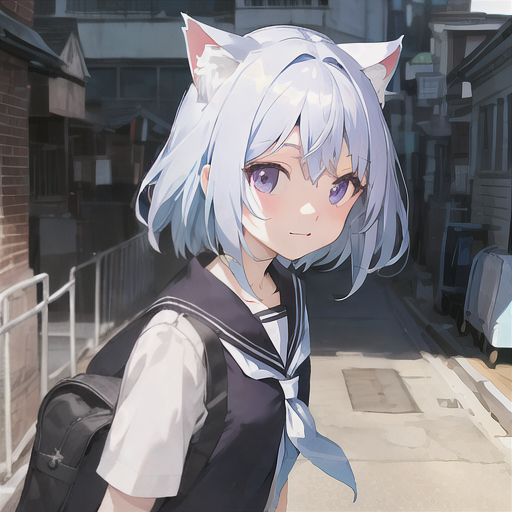

プロンプト:  (masterpiece,symmetrical clear eyes:2.0),best quality,high quality,light blue hair,1girl,smail,, medium hair, cat ears, looking at viewer, :3, cute, original, photoshop medium, purple eyes, school uniform, serafuku, short hair, simple background, solo, white background, y

1枚あたりの生成時間の平均: 14.71s


In [4]:
#@title  #Step3.画像の生成  (iamge generation){display-mode: "form"}
#from re import escape
#@markdown #自動生成

自動で条件を決めて生成 = False #@param {type:"boolean"}
auto_G=自動で条件を決めて生成
#@markdown **操作がよくわからない方はチェックをつけて下さい。自動で生成します**

#@markdown >この機能の詳細
#@markdown  * 詳細設定を推奨の値に設定
#@markdown  * プロンプトが入力されていない場合、初期値として "1girl" / "1woman" のいずれかを入力

#@markdown  >次の機能をオンにします
#@markdown   * 画面に表示
#@markdown   * 画像の質を上げるプロントを追加する
#@markdown   * プロンプトアシストを使う ( MagicPrompt )
#@markdown   * 推奨するネガティブプロントを使用
#@markdown   * 条件をメタデーターとして追加する


#@markdown

#@markdown -----

# @markdown >生成したい枚数を入力してください　/ Please enter the number of images you want to generate here.
生成する枚数 = 1 #@param {type:"slider", min:1, max:100, step:1}
枚数制限なし = False #@param {type:"boolean"}
num_imgs=生成する枚数
#if 生成する枚数 <= 0 or isinstance(生成する枚数, float):
  #  print("\033[31m警告:無効な数字が入力された為デフォルトの1枚に設定しました\033[0m")
  #  生成する枚数 = 1
#if 生成する枚数 is None:
 #   print("\033[31m警告:無効な形式な為デフォルトの1枚に設定しました\033[0m")
#    生成する枚数 = 1

# @markdown  デフォルトでは1回につき1枚生成します。(By default, one image will be generated per run.)

# @markdown ------

# @markdown  >生成する画像の条件を**英語で**入力してください　(Please input the conditions for generating images in **English**.)

Prompt = "light blue hair,1girl,smail,, medium hair, cat ears, looking at viewer, :3, cute," #@param {type:"string"}
画像の質を上げるプロントを追加する = True #@param {type:"boolean"}
add_good_prompt=画像の質を上げるプロントを追加する
#プロンプトアシストを使う = True #@param {type:"boolean"}
日本語入力 = False #@param {type:"boolean"}
JP_INPUT=日本語入力

# @markdown >**プロンプトの例**
# @markdown * cute, cat
# @markdown * Earth, space, high resolution
# @markdown * Please draw a beautiful Mount Fuji with the sun rising from the summit
# @markdown * smail,1girl, white hair, medium hair, cat ears, looking at viewer, :3, cute,white_dress


# @markdown ------
# @markdown >プロンプトアシスタントの選択
text_generate_model= "anime-anything-promptgen-v2" #@param ["None","MagicPrompt-Stable-Diffusion","anime-anything-promptgen-v2"]

# @markdown アニメ調の画像に適したアシスタントは " anime-anything-promptgen-v2 "

# @markdown 多目的のアシスタントは " MagicPrompt-Stable-Diffusion "

# @markdown 使用しない場合は " None " の選択をお願いします

条件を統一する = False #@param {type:"boolean"}

#@markdown 最初の画像のプロンプトを繰り返し使用します

# @markdown ------

# @markdown >画像を入力として送リます。

入力する画像 = "" #@param {type:"string"}
# @markdown 入力形式を "image_and_text" とした場合のみに使えます


# @markdown ------

#@markdown #詳細設定

seed = 0 # @param {type:"number"}
guidance_scale = 10 #@param {type:"slider", min:1, max:30, step:1}
momentum = 0.7 #@param {type:"slider", min:0, max:1, step:0.1}
momentum_hist = 0.6 #@param {type:"slider", min:-1, max:1, step:0.1}
history_d = "rand_new" #@param ["0", "rand_new", "rand_init"]
拡散ステップ = 30  # @param {type:"number"}
縦の大きさ = "512" #@param ["480","512","600", "768","800", "1080","1152", "1440","1920", "3840","4000","7680"]
横の大きさ = "512" #@param ["480","512","600", "768","800", "1080","1152", "1440", "1920", "3840","4000","7680"]

seedを固定する = False # @param {type:"boolean"}

if auto_G:
  guidance_scale=8.5
  momentum=0.95
  momentum_hist=0.75
  拡散ステップ=35
  縦の大きさ=512
  横の大きさ=512
  print("自動的にパラメーターが指定されました。オフにしたい場合は'自動で生成'のチェックを外してください")


sd_step=拡散ステップ
height = int(縦の大きさ)
width = int(横の大きさ)

#@markdown >用語の説明

#@markdown * seed ("0"以上) / seed値を指定します。指定しない場合ランダムな数字を割り当てます。

#@markdown * guidance_scale (5≦30 推奨"8") / どのくらい細かく描くかを指定します。

#@markdown * history_d ("0", "rand_new", "rand_init") / ’rand_init’や’rand_new’の場合、生成結果より安定します。

# @markdown * moment(0.1≦1.0 推奨"0.8") / 生成結果はより滑らかになります。

#@markdown * momentum_hist(-1.0≦1.0 推奨"0.2") / 低い場合、生成結果はより単調で反復的になります。

#@markdown * 拡散ステップ(1≦1000 推奨"50") / 計算をする回数を指定します。回数を減らすほど生成速度が速くなります

#@markdown * 縦・横の大きさ ( 推奨"512" ) / 画像の大きさを指定します。大きくすればするほど生成速度が遅くなります

# @markdown ------

# @markdown >必要であればネガティブプロンプトを入力してください。人物を生成するときにおすすめです

# @markdown よくわからない方ボタンを押してください。おすすめのネガティブプロントを使います

## @markdown (If necessary, please enter a negative prompt. It is recommended for generating characters.)

N_prompt = "logo"  # @param {type:"string"}
推奨するネガティブプロントを使用 = True #@param {type:"boolean"}
# @markdown ネガティブプロンプトとは、**ネガティブな要素を除く**ものです。

## @markdown (Negative prompts are used to exclude negative elements from an image. For example, you can use a negative prompt to exclude low quality images or images that are not beautiful.)

# @markdown ------

#@markdown >保存する先を指定します

## @markdown (If you would like to specify a location to save the generated image, please enter the path.)

保存する先のパス = ""  # @param {type:"string"}
#@markdown デフォルトでは /content/Generated_images に保存されます。なければ作るようになっています。

# @markdown >file_nameを指定します

#@markdown デフォルトは "GIMG-{number}" です

file_name = "" #@param {type:"string"}

#@markdown >file_nameの特殊トークンについて

#@markdown ファイル名にパラメータなどの値を入力できます。

#@markdown * {prompt} : Prompt

#@markdown * {seed} : seed値

#@markdown * {model_name} : model_name

#@markdown * {g_scale} : guidance_scale

#@markdown * {time} : 現在時刻

#@markdown * {number} : 生成した回数

# @markdown ------

# @markdown >グリッド画像の設定

横の画像数 = 9 # @param {type:"slider", min:2, max:10, step:1}
num_grid=int(横の画像数)
##@markdown 0の場合は、自動で設定します。

# @markdown ------

# @markdown >オプション

画像を表示 = True  # @param {type:"boolean"}
グリッド画像を表示 = True  # @param {type:"boolean"}
画像情報を表示 = True  # @param {type:"boolean"}
条件をメタデーターとして追加する = True  # @param {type:"boolean"}

#@markdown ---

警告メッセージを非表示 = True #@param {type:"boolean"}

if "pipe" not in locals():
  raise NameError("\033[33mパイプラインが見つかりませんでした。Step.2を再度実行してください\033[0m")

if "can_EN" not in locals():
  can_EN = False


if Scheduler_select=="Euler" or Scheduler_select=="EulerA":
  # choose from [0, 'rand_new', 'rand_init']
  pipe.scheduler.history_d =history_d
  # number should be between -1 and 1
  pipe.scheduler.momentum = momentum
  # number should be between -1 and 1
  pipe.scheduler.momentum_hist = momentum_hist
else:
 if not 警告メッセージを非表示:
   print('momentは、"Scheduler_selectが "Euler"、"EulerA"のいずれかでのみ有効です。')




if 入力形式=="image_and_text":
  try:#日本語が含まれていた時に備えて
    INPUT_IMG_EN = codecs.encode(入力する画像, 'utf-8')
    INPUT_IMG_DE = codecs.decode(INPUT_IMG_EN, 'utf-8')
    init_image = Image.open(INPUT_IMG_DE)
    init_image = init_image.convert("RGB")
    init_image = init_image.resize((512, 512))
  except:
    raise FileNotFoundError('入力する画像が見つかりませんでした。画像を入力しない場合は、Step.1の入力形式を"text_only"に変更お願いします')
class txt_model_setup:
  def __init__(self,Prompt,add_good_prompt,auto_G,JP_INPUT,text_generate_model):
    self.text_model_name=None
    self.pipe_name=None
    Prompt=Prompt
    self.add_good_prompt=add_good_prompt
    self.auto_G=auto_G
    JP_INPUT=JP_INPUT
    self.txt_model_name=""
    #self.txt_pipe_name=""
    text_generate_model=text_generate_model

  def option(self):
    if self.add_good_prompt or self.auto_G:
      self.mini_prompt=True
    else:
      self.mini_prompt=False
    return self.mini_prompt


  def word_preprocessing(self,JP_INPUT,Prompt):
    if not Prompt=="":
      if JP_INPUT:
        texts = Prompt
        encoded_text = codecs.encode(texts, 'utf-8')
        decoded_text = codecs.decode(encoded_text, 'utf-8')
        pos_tagger = spacy.load('en_core_web_sm')
        fugu_translator = pipeline('translation', model='staka/fugumt-ja-en')
        translation = fugu_translator(decoded_text, src_lang="ja", tgt_lang="en")[0]["translation_text"]
        Prompt_2 = translation #After_Prompt
      else:
        Prompt_2 = Prompt
    else:
      Prompt_2=random.choice(["1girl", "1woman"])
      print(f"プロンプトが未入力の為'{Prompt_2}'を入力しました")
    return Prompt_2

  def txt_G(self,Prompt_2):
    追加 = "(masterpiece,symmetrical clear eyes:2.0),best quality,high quality,"
    Prompt_4_P = self.txt_pipe_name(Prompt_2, max_length=self.max_length)[0]["generated_text"]
    if self.mini_prompt==True:
      Prompt_4=追加+Prompt_4_P
    else:
      Prompt_4=Prompt_4_P
    return Prompt_4

  def easy_prompt(self,Prompt_2,text_generate_model):
    if self.auto_G:
      text_generate_model="MagicPrompt-Stable-Diffusion"
    txt_pipe_dict={"MagicPrompt-Stable-Diffusion":("Gustavosta/MagicPrompt-Stable-Diffusion","MagicPrompt"),
                   "anime-anything-promptgen-v2":("FredZhang7/anime-anything-promptgen-v2","AnythingPrompt"),

              }
    self.txt_model_name,self.txt_pipe_name = txt_pipe_dict[text_generate_model]
    if self.mini_prompt==True:
      self.max_length=53
    else:
      self.max_length=73

    if text_generate_model == "None": # テキスト生成モデルを使わない場合
      text_model_name ="" # テキストモデル名を空にする
      Prompt_4 = Prompt_2 # プロンプトをそのまま返す

    else:
      try:
        Prompt_4 = self.txt_G(Prompt_2)
      except:
        self.txt_pipe_name=pipeline('text-generation', model=self.txt_model_name ,num_beams=3,early_stopping=False ,do_sample=True , top_k=4 , temperature=0.7)
        self.txt_pipe_name.model.config.pad_token_id = self.txt_pipe_name.model.config.eos_token_id
        Prompt_4 = self.txt_G(Prompt_2)
    return Prompt_4
#,early_stopping=Trueを削除


  def main_task(self):
    mini_prompt=self.option()
    Prompt_2=self.word_preprocessing(JP_INPUT,Prompt)
    Prompt_4=self.easy_prompt(Prompt_2,text_generate_model)
    #print('\b'*71)
    #prompt=Prompt_4
    return Prompt_4


tms=txt_model_setup(Prompt,add_good_prompt,auto_G,JP_INPUT,text_generate_model)
Prompt_4 = tms.main_task()




if 推奨するネガティブプロントを使用 or 自動で条件を決めて生成 :
  if can_EN:
    おすすめのネガティブプロント = ",<EasyNegative:2.0,bat_hands:2.0>,Loss of eye highlights:1.5,Fingers fused together:1.3,Writing Sweet Fingers:2.0,bad hands:2.0,bad legs:2.0,worst quality:2.0, low quality:2.0,Not five fingers.:2.0,blurred,Missing finger:1.7,Simple_background:2.0,Cat with deformed face:1.3 ,medium quality, purple hair,Loss of eye highlights:1.5,Fingers fused together:1.3,Writing Sweet Fingers:2.0 ,deleted:0.5, lowres,Low quality animals, deformed animals ,hands emerging from impossible places:1.7, bad anatomy, more than three limbs hands/legs:1.5, low resolution, blurry, absurdres,pixelated, sketchy, nonsensical anatomy, unrealistic pose, mosaic, unclear details, distorted colors, unrealistic proportions, poor quality, fuzzy, missing head:1.6, out of focus, hazy, grainy, text, error, missing fingers:0.9, extra digit, fewer digits, cropped, jpeg artifacts, signature, watermark, username, standard quality, bad feet_hand_finger_leg_eye, bad, text font ui, bad shadow, poorly drawn, black-white, ugly, duplicate, mutation, mutilated, malformed mutated:1.1, malformed:1.1, The background is incoherent, simple background, low-quality background, low background, bad body, long body, broken limb, anatomical nonsense, extra limbs, missing limb, incorrect limb, multiple heads, twisted head, poorly drawn face, 1 unit with multiple heads:1.3, heads together:1.0, abnormal eye:1.2 proportion, cropped:1.0, bad eyes, fused eyes, poorly drawn eyes, bad mouth, poorly drawn mouth, bad tongue, too long tongue, bad ears, poorly drawn ears, extra ears, heavy ears, long neck, too thick neck, bad neck,  bad breasts, missing arms, disappearing arms, extra arms, three arms:2.0, mutated hands and fingers, fused hand, missing fingers, extra digits, huge thighs, disappearing thigh, missing thighs, extra thighs, bad feet, huge calf, disappearing legs, bad gloves, fused gloves, beard, artist name, text watermark, unnatural, obviously wrong, distorted face, floating hair, floating body parts, severed body parts, incorrect leg position, deformed, fused body and hands, disregard of physics, distorted shape, doll-like object not present in the image, body fusion, abnormal fingers, fingers resembling fish fins, dot eyes, unclear background, mosaic, body bending, incorrect leg-to-torso ratio, excessively large breasts, unsettling appearance, eyes filled with solid color, lack of lower body, splitting, creepy doll-like appearance, distorted eyes, lines on the skin, legs bending in unnatural directions, abnormal finger count, missing arms, floating hands, lack of nose or mouth,, incorrect body part ratios, bad, longbody, lowres, bad anatomy, bad hands, missing fingers,  Distorted eye contour, Missing part from the ankles onward, extra digit, fewer digits, split wings, Vampire wings floating in the air, bad wing, comic"
  else:
    おすすめのネガティブプロント = ",Loss of eye highlights:1.5,Fingers fused together:1.3,Writing Sweet Fingers:2.0,bad hands:2.0,bad legs:2.0,worst quality:2.0, low quality:2.0,Not five fingers:2.0,blurred,Simple_background:2.0,Missing finger:1.7,Cat with deformed face:1.3 ,medium quality, purple hair,Loss of eye highlights:1.5,Fingers fused together:1.3,Writing Sweet Fingers:2.0 ,deleted:0.5, lowres,Low quality animals, deformed animals ,hands emerging from impossible places:1.7, bad anatomy, more than three limbs hands/legs:1.5, low resolution, blurry, absurdres,pixelated, sketchy, nonsensical anatomy, unrealistic pose, mosaic, unclear details, distorted colors, unrealistic proportions, poor quality, fuzzy, missing head:1.6, out of focus, hazy, grainy, text, error, missing fingers:0.9, extra digit, fewer digits, cropped, jpeg artifacts, signature, watermark, username, standard quality, bad feet_hand_finger_leg_eye, bad, text font ui, bad shadow, poorly drawn, black-white, ugly, duplicate, mutation, mutilated, malformed mutated:1.1, malformed:1.1, The background is incoherent, simple background, low-quality background, low background, bad body, long body, broken limb, anatomical nonsense, extra limbs, missing limb, incorrect limb, multiple heads, twisted head, poorly drawn face, 1 unit with multiple heads:1.3, heads together:1.0, abnormal eye:1.2 proportion, cropped:1.0, bad eyes, fused eyes, poorly drawn eyes, bad mouth, poorly drawn mouth, bad tongue, too long tongue, bad ears, poorly drawn ears, extra ears, heavy ears, long neck, too thick neck, bad neck,  bad breasts, missing arms, disappearing arms, extra arms, three arms:2.0, mutated hands and fingers, fused hand, missing fingers, extra digits, huge thighs, disappearing thigh, missing thighs, extra thighs, bad feet, huge calf, disappearing legs, bad gloves, fused gloves, beard, artist name, text watermark, unnatural, obviously wrong, distorted face, floating hair, floating body parts, severed body parts, incorrect leg position, deformed, fused body and hands, disregard of physics, distorted shape, doll-like object not present in the image, body fusion, abnormal fingers, fingers resembling fish fins, dot eyes, unclear background, mosaic, body bending, incorrect leg-to-torso ratio, excessively large breasts, unsettling appearance, eyes filled with solid color, lack of lower body, splitting, creepy doll-like appearance, distorted eyes, lines on the skin, legs bending in unnatural directions, abnormal finger count, missing arms, floating hands, lack of nose or mouth,, incorrect body part ratios, bad, longbody, lowres, bad anatomy, bad hands, missing fingers,  Distorted eye contour, Missing part from the ankles onward, extra digit, fewer digits, split wings, Vampire wings floating in the air, bad wing, comic"
else:
  おすすめのネガティブプロント =""


negative_prompt2 = N_prompt + おすすめのネガティブプロント

if 枚数制限なし:
  生成する枚数=100000
st=生成する枚数

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

if 保存する先のパス:
  if not Google_driveに接続:
    if "/content/drive/MyDrive" in 保存する先のパス:
      image_save_path="/content/生成した画像"
      print("\033[31mGoogleドライブに接続されていないためデフォルトのパスに保存しました\033[0m")
    else:
      image_save_path=保存する先のパス
  else:
    image_save_path=保存する先のパス
else:
  image_save_path="/content/Generated_images"
if not os.path.exists(image_save_path):
      os.makedirs(image_save_path)

if not os.path.exists("/content/Grid_img"):
      os.makedirs("/content/Grid_img")



if seed is None:
  seed=0
#  seed = random.randint(1,1000000)

#generator = torch.Generator("cuda").manual_seed(seed)

def seed_set(seed):
  #global seed, generator
  if seed==0:
    seed = random.randint(1,1000000)
  else:
    seed=seed
  generator = torch.Generator("cuda").manual_seed(seed)
  return seed,generator
seed,generator=seed_set(seed)


def path_new_set(image_save_path,file_name_old,i):
  file_name_old=path_token(Prompt_4,seed,model_name,guidance_scale,file_name)
  now_t=datetime.now()
  file_new= (f"{file_name_old}.png")
  file_test = os.path.join(image_save_path , file_new)
  if os.path.exists(file_test):
     file_new=(f"{file_name_old}-{now_t}.png")
     print('既に同じ名前のファイルが存在したため、ファイル名に" data_time "を追加しました。')
  path_new = os.path.join(image_save_path , file_new)
  return path_new,file_new

def YU():
  try:
    y+=1
  except:
    y=1
  return y
y=YU()


def path_token(Prompt_4,seed,model_name,guidance_scale,file_name):
    global z
    try:
      z+=1
    except:
      z=1
    file_name_old=""
    if not file_name:
      file_name=("GIMG-{number}")
    now = datetime.now()
    file_name_encoded = codecs.encode(file_name, 'utf-8')
    file_name_decoded = codecs.decode(file_name_encoded, 'utf-8')
    path_d = {"{prompt}":Prompt_4,"{seed}": seed, "{model_name}": model_name, "{g_scale}": guidance_scale,"{time}":now ,"{number}":z}
    for key, value in path_d.items():
       # valueという引数に渡す値をstr関数で文字列型に変換する
      file_name_old = file_name_decoded.replace(key, str(value))
    return file_name_old

def grid_making(num_imgs,grid_imgs,height,width):
  quotient_1,remainder = num_imgs % 4,num_imgs % 4#商、余りをまとめて求める
  if remainder!=0:
    quotient=quotient_1+1
  else:
    quotient=quotient_1
  white_img = Image.new("RGB", (height,width), (255, 255, 255)) # 400x400の白い画像を作成します。
  # grid_imgsに白い画像を追加します。appendメソッドを使うことでリストに任意のオブジェクトを追加することができます。
  for i in range(remainder):
    grid_imgs.append(white_img)
  return grid_imgs,quotient


def generate_images(num_grid,y,st,seed,generator,Prompt_4,image_save_path,sd_step,model_name,file_name):
    i=1
    T=1
    generate_time_all=0
    generate_start_time=0
    generate_end_time=0
    grid_imgs=[]
    num_cols=3
    num_rows=2#たて
    grid_path=(f"/content/Grid_img/grid_imgs-{y}.png")
    for i in range(生成する枚数):
      #file_name_old=path_token(Prompt_4,seed,model_name,guidance_scale,file_name)

      path_new,file_new=path_new_set(image_save_path,file_name,i)

      if not 条件を統一する:
        if i > 1:
          Prompt_4 = tms.main_task()
      if not seedを固定する:
        if i >=1:
          if seed==0:
            seed = random.randint(1,1000000)
      else:
        if seed==0:
          seed = random.randint(1,1000000)
      #generate_start_time = time.time()
      j=i+1
      now = datetime.now()
      date_str = now.strftime("%Y-%m-%d_UTC-%H:%M:%S")
      path = os.path.join(image_save_path, file_name)
      generate_start_time = time.time()
      if 入力形式 == "image_and_text":
        with torch.inference_mode():
          result = pipe(Prompt_4,image=init_image, negative_prompt=negative_prompt2, num_inference_steps=sd_step,guidance_scale=guidance_scale,generator=generator)
        make_image = result.images[0]
      else:
        with torch.inference_mode():
          result = pipe(Prompt_4, negative_prompt=negative_prompt2, guidance_scale=guidance_scale, num_inference_steps=sd_step,height=height,width=width,generator=generator)
        make_image = result.images[0]

      info = make_image.info
      if 条件をメタデーターとして追加する or 自動で条件を決めて生成:
        metadata = {
            "Seed": seed,
            "model": model_name,
            "G_scale":guidance_scale,
            "D_step":sd_step,
            "Prompt": Prompt_4,
            "n_prompt":negative_prompt2
           }
        pnginfo = PngImagePlugin.PngInfo()
        for key, value in metadata.items():
            pnginfo.add_text(key, str(value))
        make_image.save(path_new, pnginfo=pnginfo)
      else:
        make_image.save(path_new)

      generate_end_time = time.time()
      generate_time = generate_end_time - generate_start_time
      generate_time_all += generate_time
      generate_time_after=("{:.2f}s".format(generate_time))
      if 枚数制限なし:
          print(f"\033[34m画像生成が完了しました ({j}/∞)  {generate_time_after}")
      else:
          print(f"\033[34m画像生成が完了しました ({j}/{st})  {generate_time_after}")
      if 画像情報を表示:
          print(f"\033[32mseed値: {seed}")
          print(f"ファイルの名前:( \033[32m{file_new}\033[34m )")
          print(f"保存先のパス:( \033[32m{path_new}\033[34m )")
          print('メタデータをご覧になる場合は、「保存先のパス」をコピー＆ペーストしてください')
          print("上記のようになります。ご確認ください\033[0m")

      if 画像を表示 or auto_G:
        imgN = Image.open(path_new)
        display(imgN)
      if 画像情報を表示:
        print('\033[92mプロンプト:  ' + Prompt_4 + '\033[0m\n')  # "\033[38;2;135;206;235m" はスカイブルー    "\033[38;2;255;165;0m"はオレンジ
      img = Image.open(path_new)
      grid_imgs.append(img)
    generate_time_all_after=generate_time_all/生成する枚数
    #remainder=1

    if num_grid>生成する枚数:
      num_grid=生成する枚数
      quotient_1=1
      remainder=0
    else:
      quotient_1,remainder =divmod(生成する枚数,num_grid) #商、余りをまとめて求める
    num_White_image=num_grid-remainder
    if remainder!=0:
      white_img = Image.new("RGB", (height,width), (255, 255, 255)) # 400x400の白い画像を作成します。
      for T in range(num_White_image):
        grid_imgs.append(white_img)
      quotient=quotient_1+1
    else:
      quotient=quotient_1
    if 生成する枚数!=1:
      grid = image_grid(grid_imgs, rows=quotient, cols=num_grid)
      grid.save(grid_path)
      grid_img = Image.open(grid_path)
      if グリッド画像を表示 or auto_G:
        display(grid_img)
    print("\033[38;2;135;206;235m1枚あたりの生成時間の平均: {:.2f}s\033[0m".format(generate_time_all_after))
generate_images(num_grid,y,st,seed,generator,Prompt_4,image_save_path,sd_step,model_name,file_name)

In [ ]:
#@title  {display-mode: "form"}
#@markdown >画像を指定してダウンロードします。

from google.colab import files
import shutil
import os
画像のパス = "" #@param {type:"string"}
try:
  files.download(画像のパス)
  print("\033[32mダウンロードが正常に完了しました")
except:
  print("\033[31m画像が見つかりませんでした\033[0m")

In [ ]:
#@title メモリの初期化(Beta) {display-mode: "form"}
import gc

if "pipe" in globals():
    del pipe
if "make_images" in globals():
    del make_images
torch.cuda.empty_cache()
gc.collect()

In [ ]:
#@title 画像のメタデータを見る  {display-mode: "form"}
from PIL import Image, PngImagePlugin
import os
image_metadata_path = "" #@param {type:"string"}
if not os.path.exists(image_metadata_path):
  raise FileNotFoundError("ファイルが見つかりませんでした")
try:
  output_info = Image.open(image_metadata_path).info
except:
  raise FileNotFoundError("画像を読み込めませんでした")

try:
  print("seed: "+output_info["Seed"]+"\n")
  print("diffusion_step: "+output_info["D_step"]+"\n")
  print("guidance_scale: "+output_info["G_scale"]+"\n")
  print("model_name : "+output_info["model"]+"\n")
  print("prompt: \033[92m"+output_info["Prompt"]+"\033[0m\n")
except:
  print("\033[31mメタデーターが見つかりませんでした\033[0m")

In [ ]:
#@title 高画質化  {display-mode: "form"}
from PIL import Image
from io import BytesIO
from diffusers import StableDiffusionUpscalePipeline
import torch

# load model and scheduler
Prompt = "" #@param {type:"string"}
prompt="masterpiece:2.0,best quality,high quality,"+Prompt
low_res_img_path = "" #@param {type:"string"}
encoded_text = codecs.encode(low_res_img_path, 'utf-8')
low_res_img_path = codecs.decode(encoded_text, 'utf-8')

if "pipeline2" not in locals()  and "pipeline2" not in globals():
  model_id = "stabilityai/stable-diffusion-x4-upscaler"
  pipeline2 = StableDiffusionUpscalePipeline.from_pretrained(
    model_id, revision="fp16", torch_dtype=torch.float16
  )
  pipeline2 = pipeline2.to("cuda")
if not os.path.exists(low_res_img_path):
  raise FileNotFoundError("ファイルが見つかりませんでした")
try:
  low_res_img = Image.open(low_res_img_path)
except:
  raise FileNotFoundError("画像を読み込めませんでした")
low_res_img = low_res_img.resize((128, 128))

negative_prompt="low quality:2.0"

upscaled_image = pipeline2(prompt=prompt, image=low_res_img,negative_prompt=negative_prompt).images[0]

try:
  L+=1
except:
  L=1
path1=(f"/content/low_res_imgNo{L}.png")
upscaled_image.save(path1)
print(f"画像保存パス: ({path1})")

In [ ]:
#@title 画像フォルダを削除  {display-mode: "form"}
import shutil
画像フォルダを削除 = False #@param {type:"boolean"}
#@markdown /content/Generated_imagesを削除します
if 画像フォルダを削除==True:
  YorS=input("本当に削除しますか？[yes/no]: ")
  if YorS=="yes":
    try:
      shutil.rmtree('/content/Generated_images')
    except:
      print("\033[31m/content/Generated_images が見つかりませんでした\033[0m")
  elif YorS=="no":
    print("フォルダの削除を中止しました")
  else:
    print("yes/no のみの入力をお願いします。")

else:
  print("削除する場合、ボックスにチェックを入れたのち、再度実行お願いします。")

In [ ]:
#@title  {display-mode: "form"}
#@markdown >zip形式にしてダウンロードします。
#@markdown 未入力の場合のフォルダ:  /content/Generated_images
images_save_dir_path= "" #@param {type:"string"}

if images_save_dir_path=="":
  images_save_dir_path="/content/Generated_images"
from google.colab import files
import shutil
import os

try:
  zip_number=zip_number+1
except:
  zip_number=1

zip_name=f"Generated_images-No.{zip_number}"
zip_save_dir=os.path.join("/content",zip_name)
zippath=zip_save_dir+".zip"
try:
  shutil.make_archive(zip_save_dir, "zip", images_save_dir_path)
  files.download(zippath)
  print("\033[32mzipファイルへ圧縮が正常に完了しました")
  print(f'zipファイル名前は\033[34m"{zip_name}"\033[32mですご確認ください\033[0m')
except:
  print("\033[31m生成した画像が見つかりませんでした\033[0m")

In [ ]:
#@title  {display-mode: "form"}
ランタイムを初期化する = False #@param {type: 'boolean'}
#@markdown 作業を終了するときにチェックを入れたのち実行してください。
if  ランタイムを初期化する == True:
    from google.colab import runtime
    runtime.unassign()

else:
  print('ランタイムの切断をキャンセルしました')

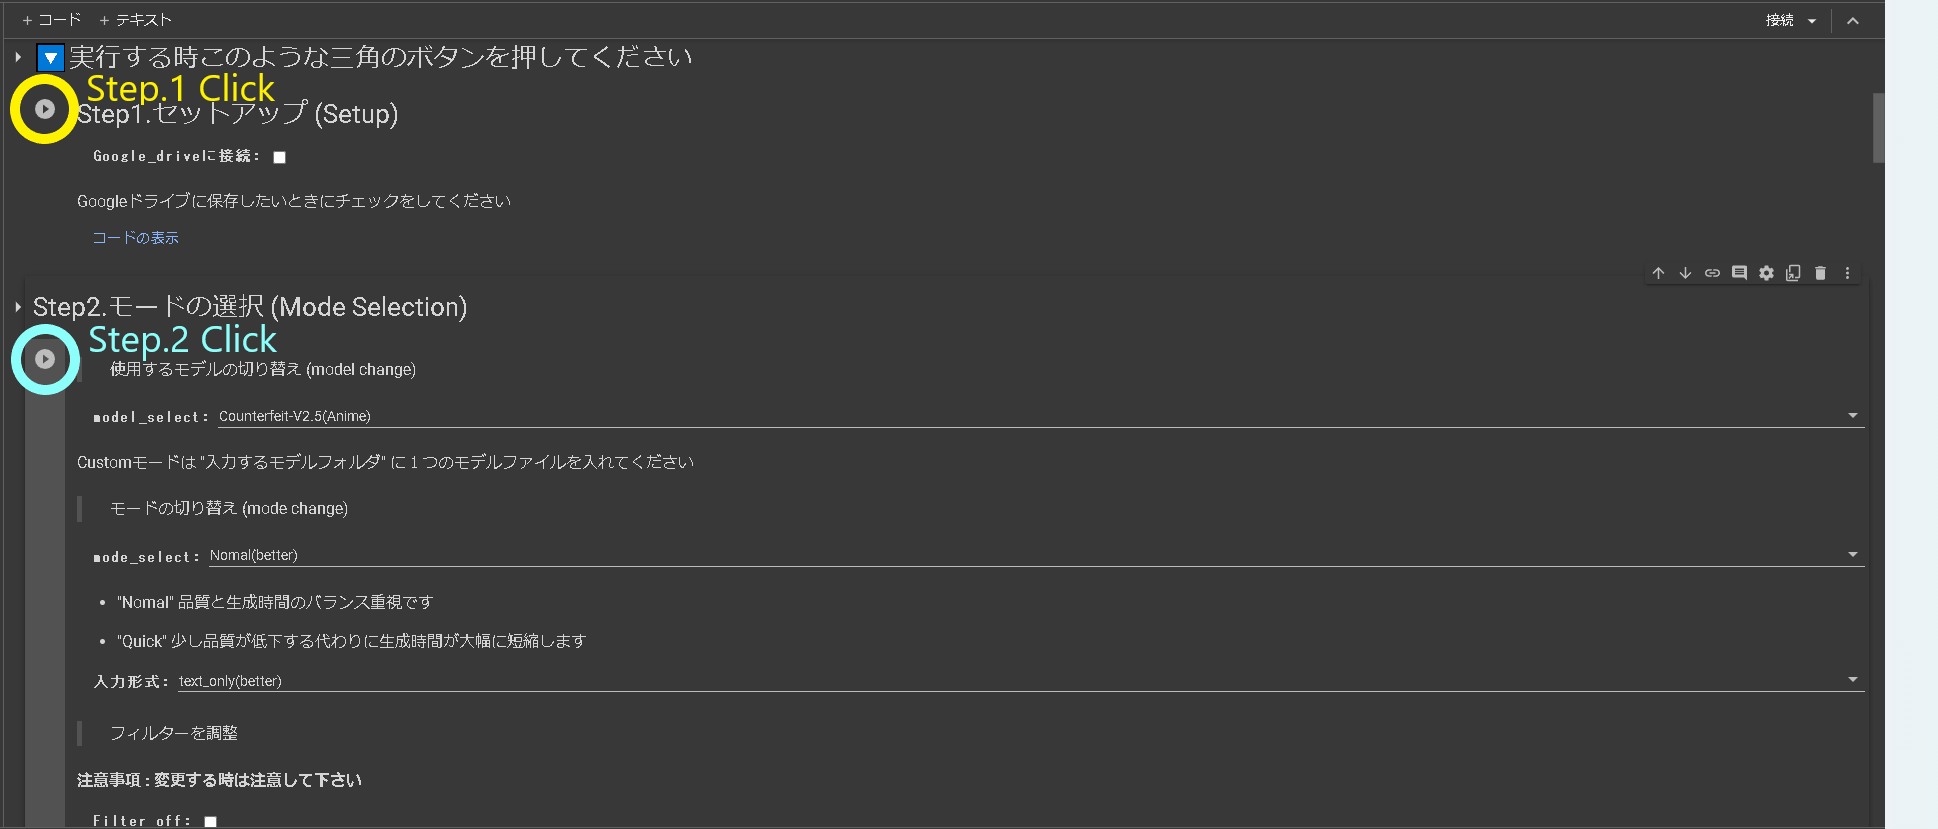

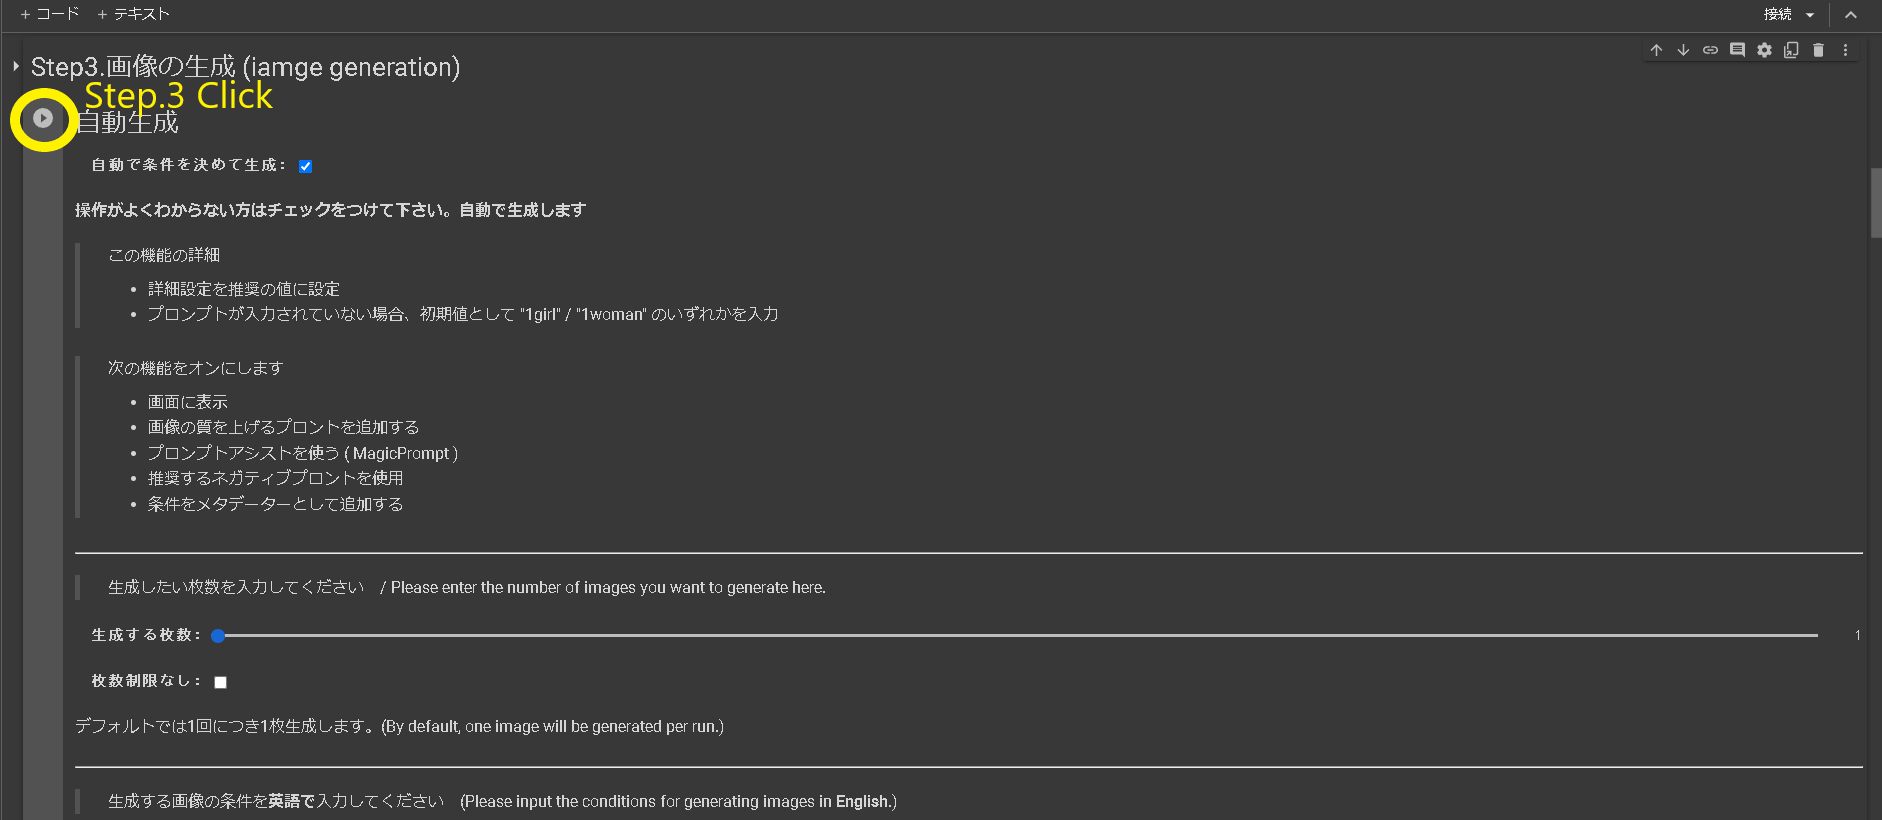

In [ ]:
#@title   {display-mode: "form"}
#@markdown #**Image generation methods**
I1=Image.open("/content/IMG_2082.png")
display(I1)
I2=Image.open("/content/IMG_2083.png")
display(I2)

Step.1


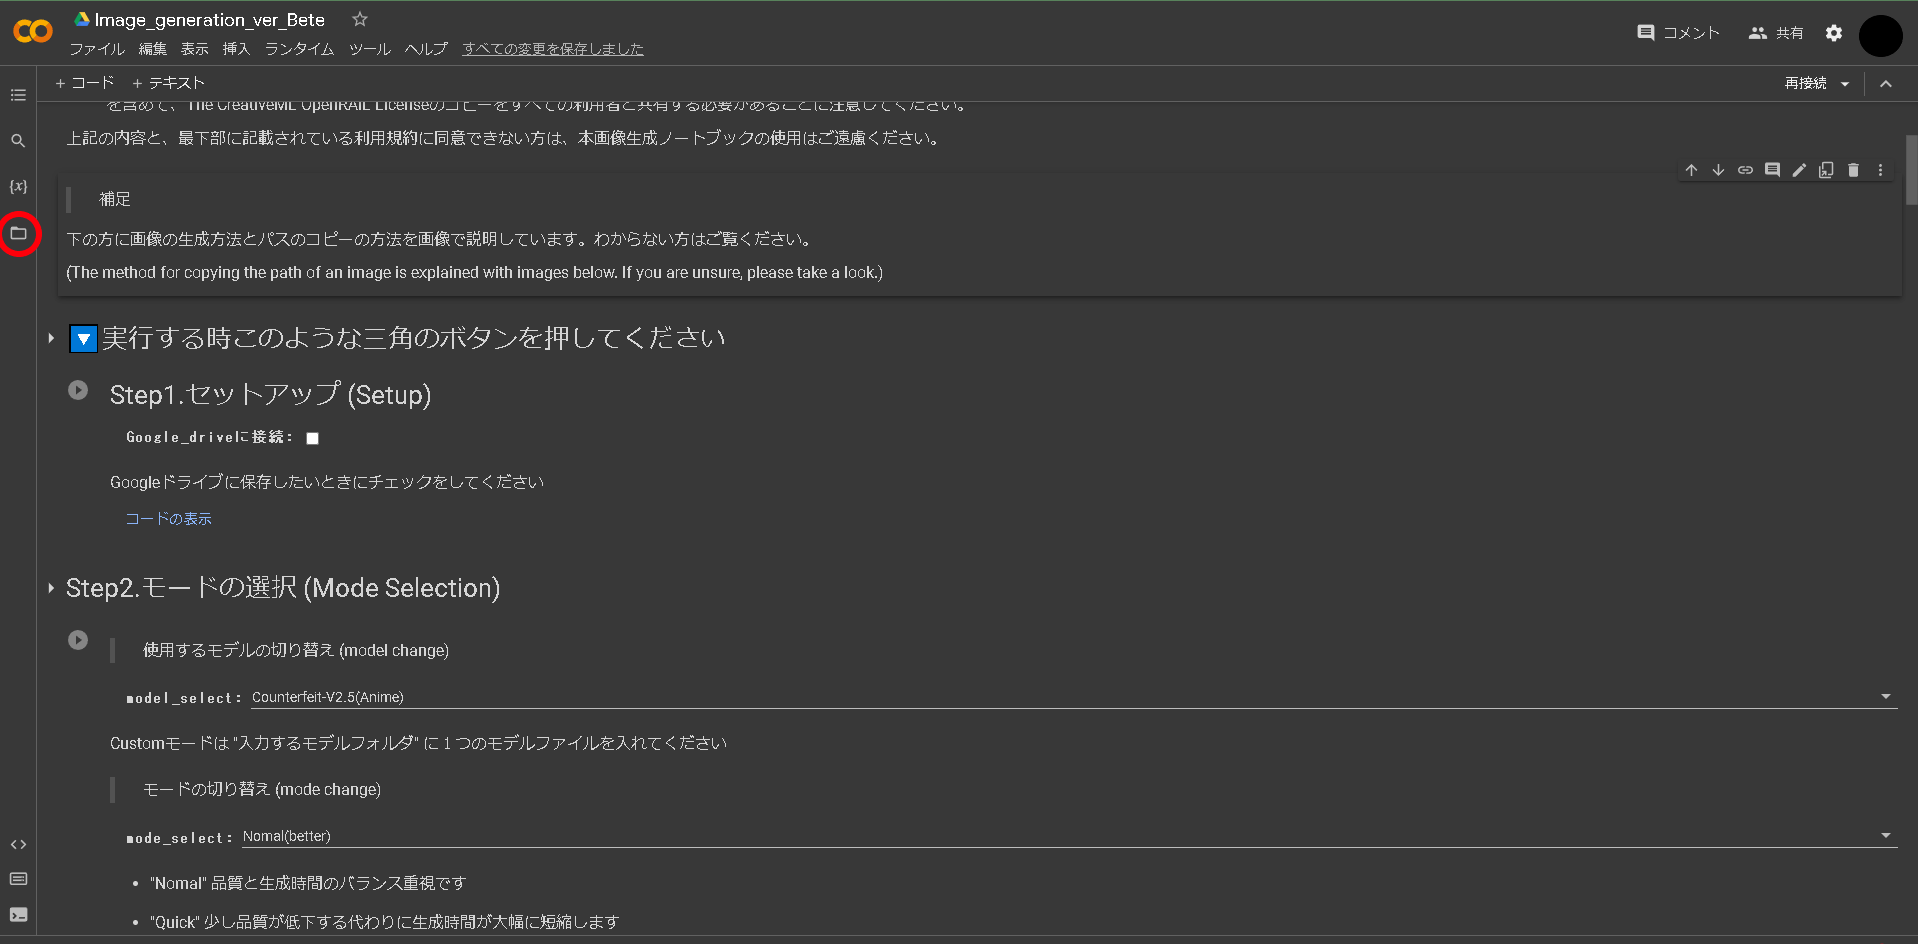

Step.2


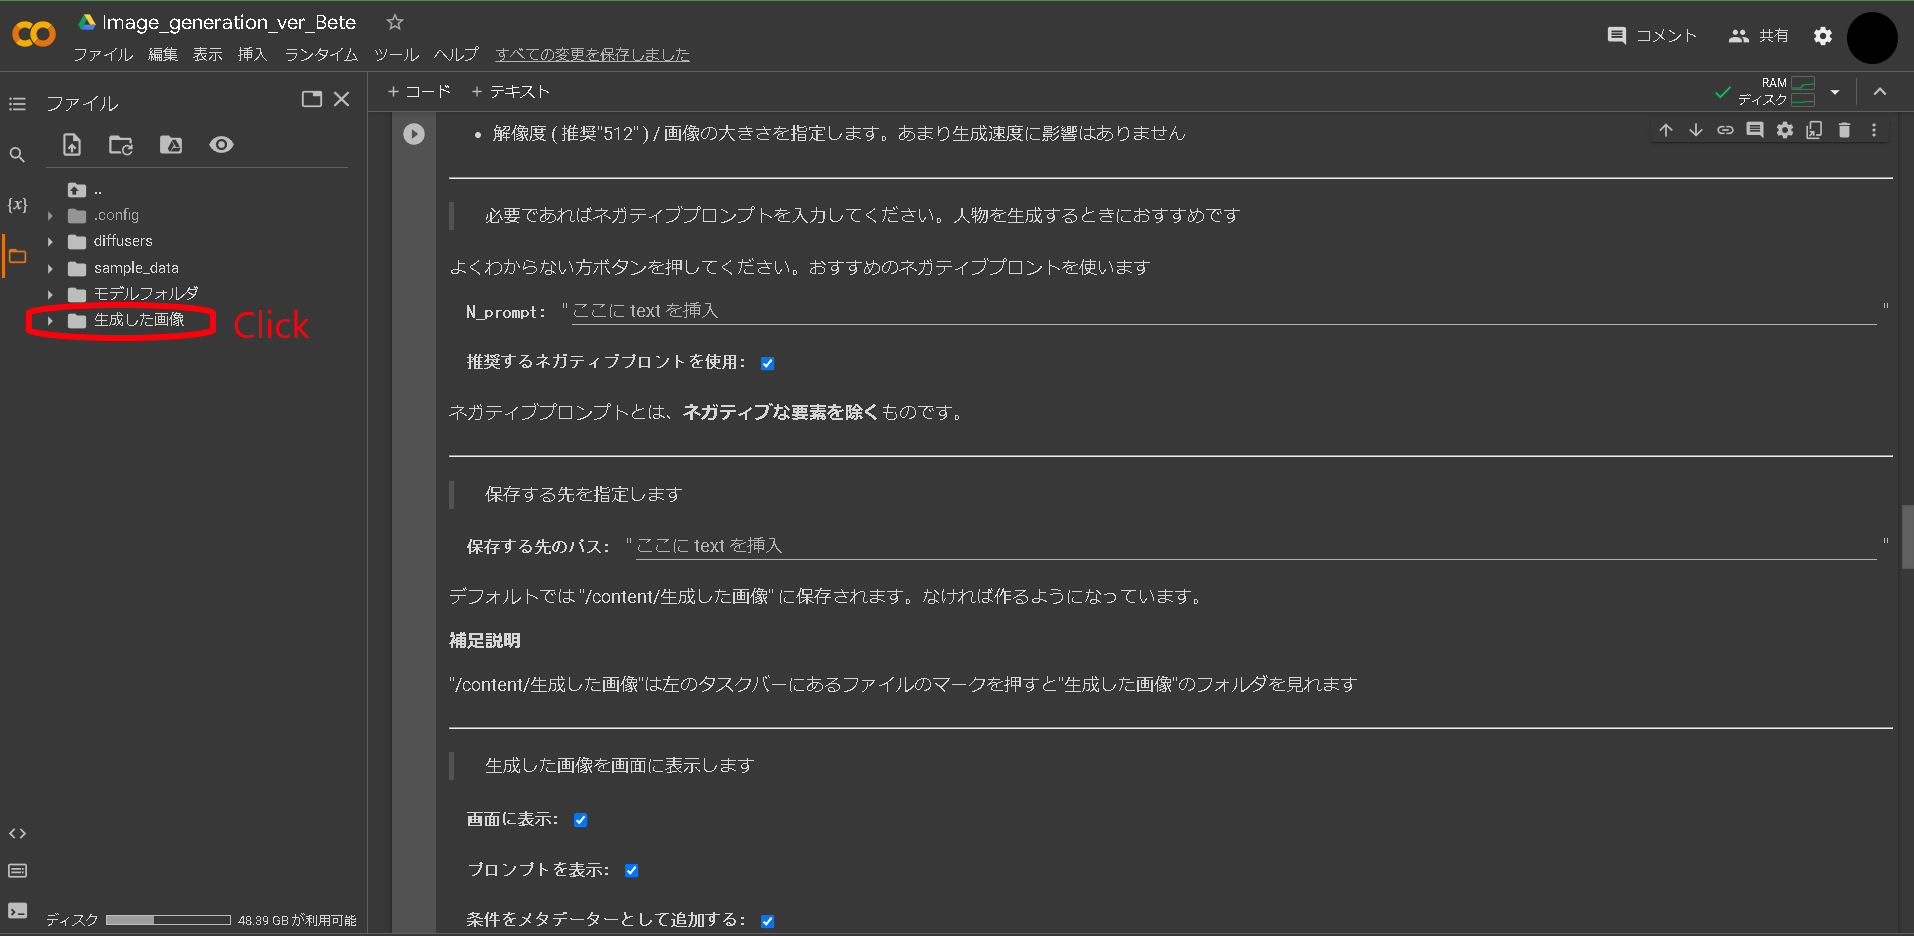

Step.3


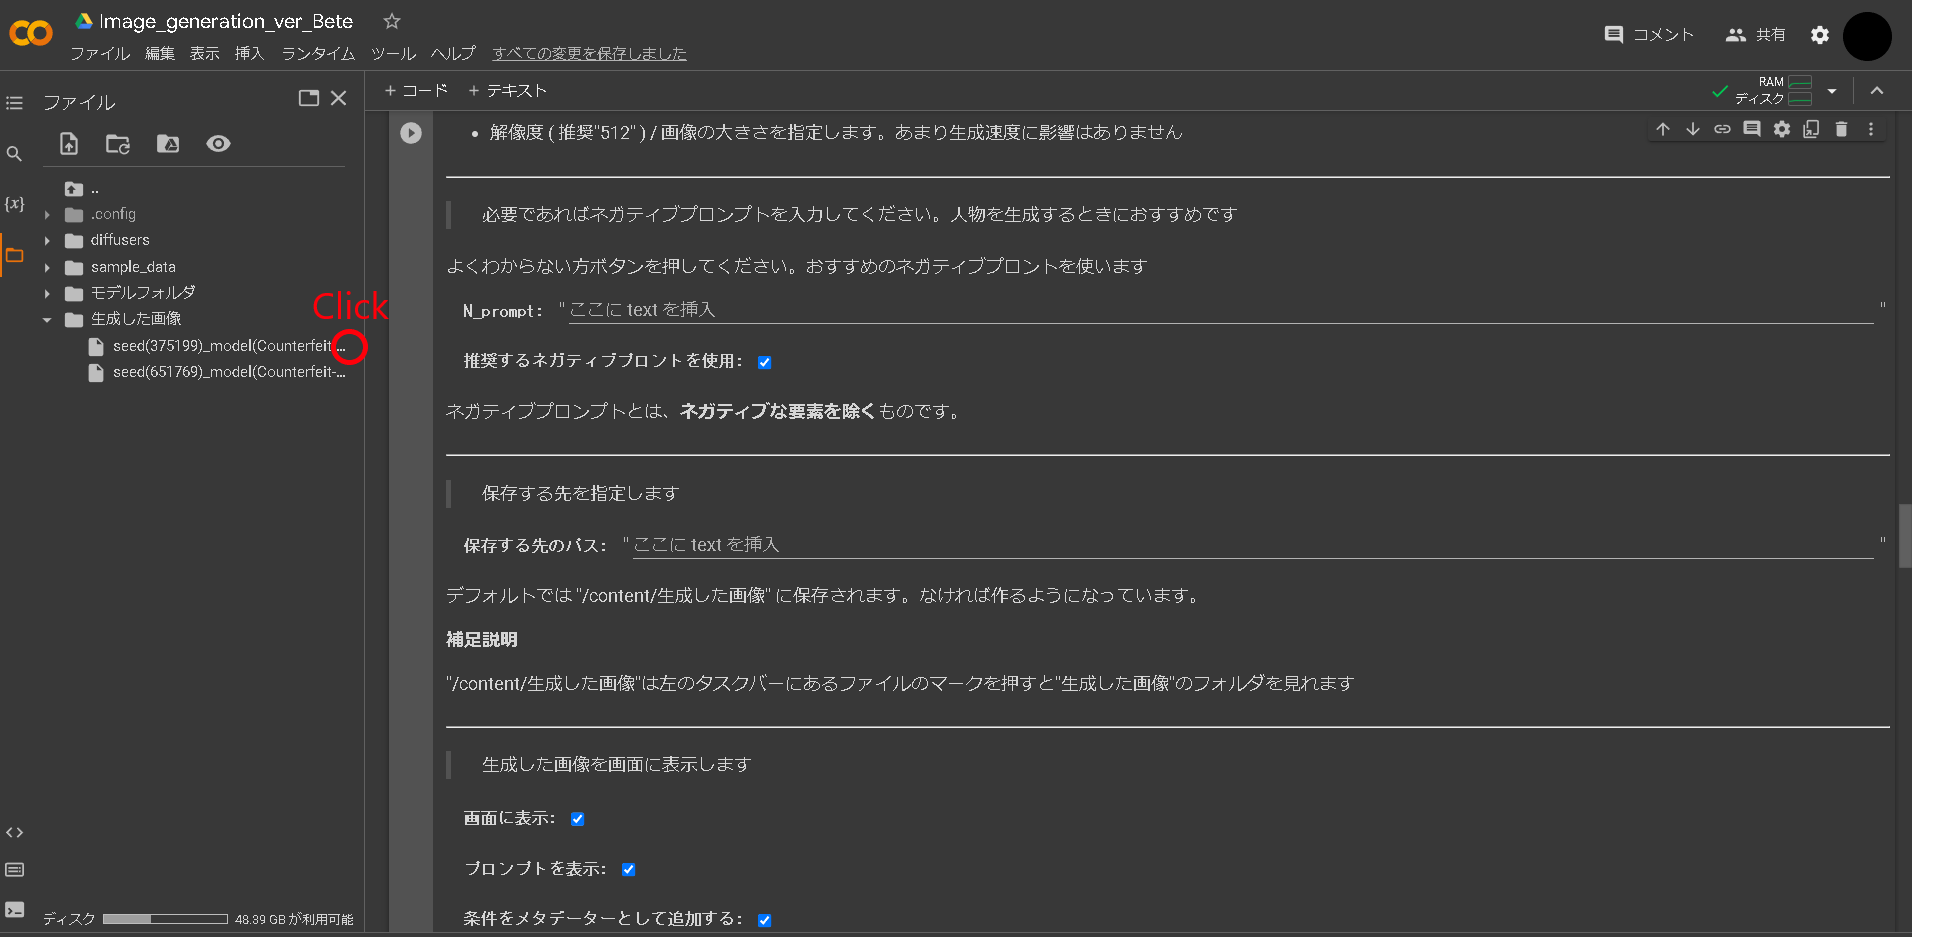

Step.4


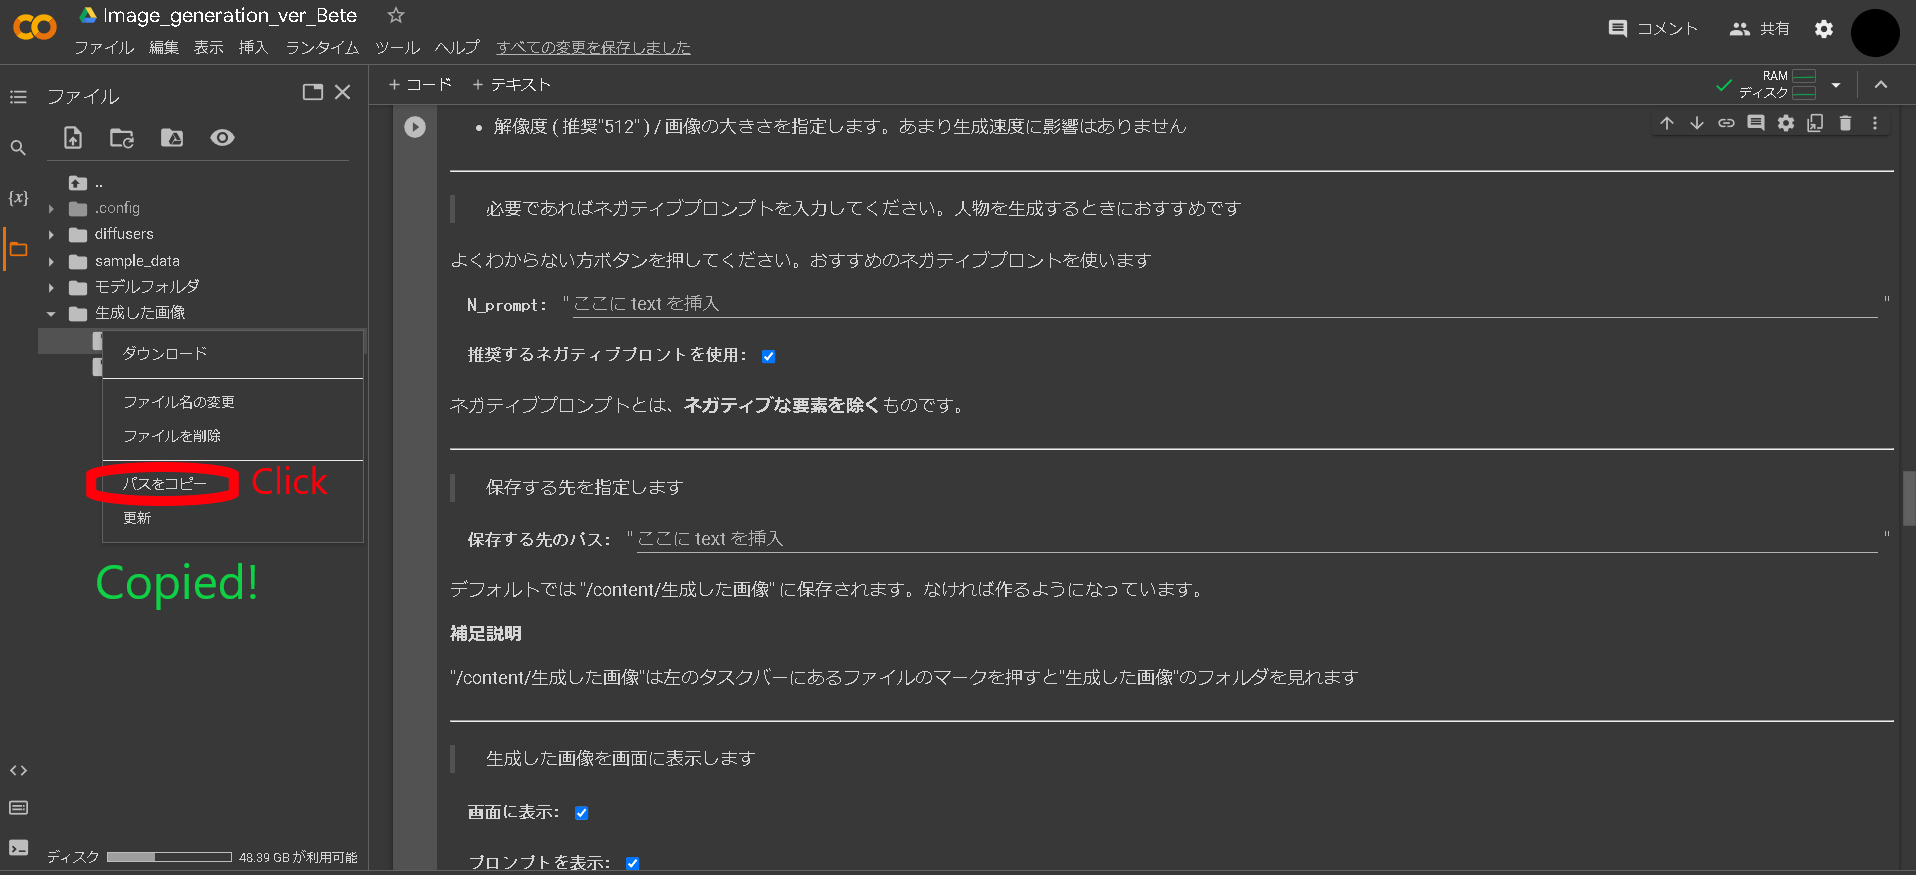

In [ ]:
#@title   {display-mode: "form"}
#@markdown #**How to copy the path of an image**

#@markdown Please modify the steps as needed
print("Step.1")
IM1=Image.open("/content/IMG_2085.png")
display(IM1)
print("Step.2")
IM2=Image.open("/content/IMG_2086.png")
display(IM2)
print("Step.3")
IM3=Image.open("/content/IMG_2087.png")
display(IM3)
print("Step.4")
IM4=Image.open("/content/IMG_2088.png")
display(IM4)

埋め込みが適用可能なのは、追加学習のベースモデルがstable diffusion-v1.5までのバージョンのみです。
現在の最新のバージョンであるstable diffusion-v2.1をベースモデルとしたものには使用できません。

#**Readme**(日本語版)
#利用規約

本画像生成ノーブックを使用するにあたって、利用規約の内容に全て同意したとみなします。

# **重要な注意点**：
* **商用利用はご遠慮ください。**
* **画像生成によって起こった問題について、私は一切責任を負いません。**

>免責事項:
*  使用にあたっては、自己責任でお願いします。
*  本モデルは予告なく変更・非公開・削除する可能性があります。
*  利用規約は予告なく変更する場合があります。
*  このモデルは、趣味で作成したものであり、商用利用などは意図していません。
*  使用にあたって発生した通信量、電気料金など金銭に関わるものの負担は追い兼ねます
*  Stable Diffusion-Ver2.1やその他の追加ライブラリに関する規約がある場合は、それらも確認することを強くお勧めします。
*  本プロジェクトを利用することにより生じた一切の問題について、私は一切責任を負いません。

ー本プロジェクトとは、本画像生成ノートブックや、githubのページなどをさします
___
#本プロジェクトの説明
Stable Diffusion-Ver2.1をベースにした画像生成ノートブックです。


>使用させていただいたライブラリ
- Stable Diffusion-ver2.1
- CLIP
- tqdm
- ftfy
- scipy
- regex
- torch
- diffusers
- accelerate
- safetensors
- transformers

※2023/5/12時点
---

謝辞

本画像生成ノートブックの作成にあたり、オープンソースのリソースやフリーのツールを使用させていただきました。個人的な利用でしたが、これらのリソースやツールがあったからこそ、本プロジェクトを実現することができました。
この場を借りて、オープンソースのコミュニティや、フリーのツールを提供してくださった方々に感謝の意を表します。素晴らしいツールや技術を提供してくださり、本プロジェクトを支援してくださったことに心から感謝いたします。

#**Readme(English_ver)**
# Terms of Use

By using this image generation notebook, you agree to all the contents of the Terms of Use.

Important Notice:
**Please refrain from using for commercial purposes.**
**I am not responsible for any problems caused by image generation.**

>Disclaimer:
* Please use it at your own risk.
* This NoteBook may be changed, unpublished, or deleted without notice.
* The terms of use may be changed without notice.
* This NoteBook is created for personal use and is not intended for commercial use.
* If there are terms and conditions for Stable Diffusion-Ver2.1 and other additional libraries, it is strongly recommended to confirm them as well.
* I am not responsible for any problems caused by using this project.

ー This project refers to the image generation notebook and GitHub pages.

---

# Description of this project

This is an image generation notebook based on Stable Diffusion-Ver2.1.

**Tools used**
* As of 2023/5/12

>**Libraries used**
- Stable Diffusion-ver2.1
- CLIP
- tqdm
- ftfy
- scipy
- regex
- torch
- diffusers
- accelerate
- safetensors
- transformers

---

# Acknowledgements

I used open source resources and free tools to create this image generation notebook. Although it was for personal use, it was only possible to realize this project because of these resources and tools.
I would like to express my gratitude to the open source community and those who provide free tools. I sincerely appreciate your support for this project by providing great tools and technologies.
